Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term
Compiling model...
Building feed-forward neural network...

'build' took 0.191208 s



c:\Users\yesda\anaconda3\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(



'compile' took 0.560293 s

Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [1.44e+01, 3.03e-02, 4.16e-01, 7.08e-02]    [1.69e+01, 3.03e-02, 4.16e-01, 7.08e-02]    [8.87e-01]    
0 [2.00e+00]
1000      [5.55e-03, 2.05e-02, 4.78e-02, 1.60e-02]    [5.88e-03, 2.05e-02, 4.78e-02, 1.60e-02]    [3.98e-01]    
1000 [1.96e+00]
2000      [2.01e-03, 3.85e-03, 1.25e-02, 6.95e-03]    [2.70e-03, 3.85e-03, 1.25e-02, 6.95e-03]    [3.70e-01]    
2000 [1.62e+00]
3000      [5.71e-04, 7.15e-04, 1.90e-03, 2.23e-03]    [1.55e-03, 7.15e-04, 1.90e-03, 2.23e-03]    [2.07e-01]    
3000 [1.27e+00]
4000      [1.13e-04, 1.72e-04, 4.01e-05, 1.96e-04]    [4.94e-04, 1.72e-04, 4.01e-05, 1.96e-04]    [5.88e-02]    
4000 [1.07e+00]
5000      [7.62e-05, 7.57e-05, 1.17e-05, 3.61e-05]    [2.60e-04, 7.57e-05, 1.17e-05, 3.61e-05]    [2.49e-02]    
5000 [1.03e+00]
6000      [4.95e-05, 3.53e-05, 4.49e-06, 1.33e-05]    [1.87e-04, 3.53

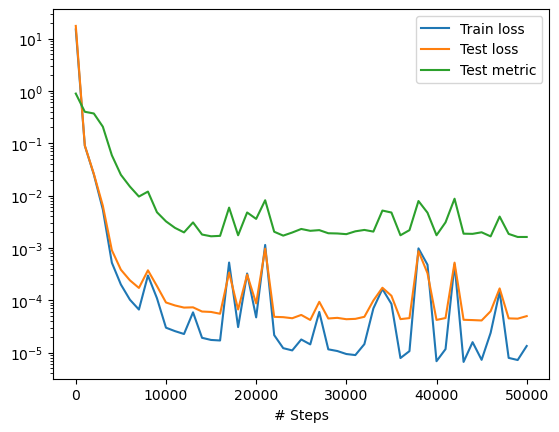

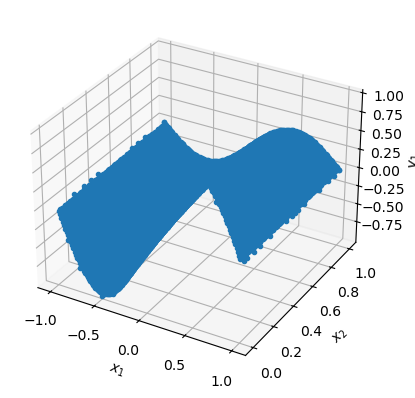

In [1]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import numpy as np
# Backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf
# Backend pytorch
# import torch
# Backend paddle
# import paddle


C = dde.Variable(2.0)


def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    # Backend tensorflow.compat.v1 or tensorflow
    return (
        dy_t
        - C * dy_xx
        + tf.exp(-x[:, 1:])
        * (tf.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * tf.sin(np.pi * x[:, 0:1]))
    )
    # Backend pytorch
    # return (
    #     dy_t
    #     - C * dy_xx
    #     + torch.exp(-x[:, 1:])
    #     * (torch.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * x[:, 0:1]))
    # )
    # Backend paddle
    # return (
    #     dy_t
    #     - C * dy_xx
    #     + paddle.exp(-x[:, 1:])
    #     * (paddle.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * paddle.sin(np.pi * x[:, 0:1]))
    # )


def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])


geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)

observe_x = np.vstack((np.linspace(-1, 1, num=10), np.full((10), 1))).T
observe_y = dde.icbc.PointSetBC(observe_x, func(observe_x), component=0)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic, observe_y],
    num_domain=40,
    num_boundary=20,
    num_initial=10,
    anchors=observe_x,
    solution=func,
    num_test=10000,
)

layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

model.compile(
    "adam", lr=0.001, metrics=["l2 relative error"], external_trainable_variables=C
)
variable = dde.callbacks.VariableValue(C, period=1000)
losshistory, train_state = model.train(iterations=50000, callbacks=[variable])

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
Building feed-forward neural network...
'build' took 0.051463 s



c:\Users\yesda\anaconda3\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.537755 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [6.36e+00]    [6.76e+00]    [5.29e-01]    
1000      [9.01e-04]    [1.05e-03]    [1.61e-03]    
2000      [9.40e-05]    [2.71e-04]    [7.49e-04]    
3000      [1.15e-04]    [3.01e-04]    [1.64e-03]    
4000      [9.52e-05]    [2.60e-04]    [3.09e-03]    
5000      [2.14e-04]    [3.53e-04]    [2.39e-03]    
6000      [3.26e-04]    [4.50e-04]    [8.59e-03]    
7000      [3.19e-05]    [1.52e-04]    [8.35e-04]    
8000      [2.70e-05]    [1.37e-04]    [6.62e-04]    
9000      [4.65e-05]    [1.48e-04]    [1.06e-03]    
10000     [2.00e-05]    [1.10e-04]    [5.50e-04]    

Best model at step 10000:
  train loss: 2.00e-05
  test loss: 1.10e-04
  test metric: [5.50e-04]

'train' took 6.837541 s

Saving loss history to c:\Users\yesda\OneDrive - Aalto University\Aalto Work\2023Hydrogen\Code\PINN_testing\loss.dat ...
Saving training data to c:\Users\yesda\OneDrive - Aalto University\Aalto 

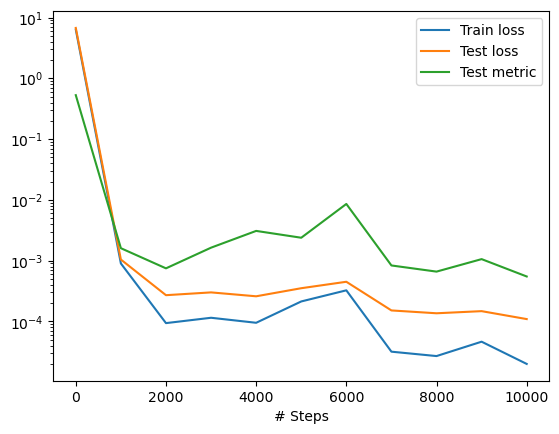

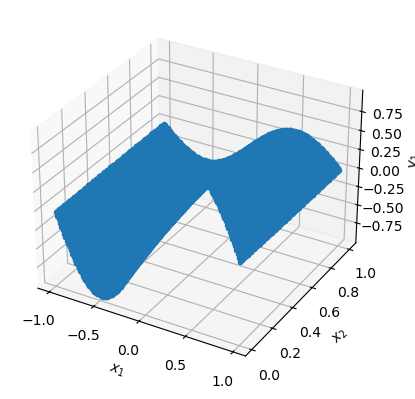

In [2]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import deepxde as dde
import numpy as np
# Backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf
# Backend pytorch
# import torch
# Backend jax
# import jax.numpy as jnp
# Backend paddle
# import paddle


def pde(x, y):
    # Most backends
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    # Backend jax
    # dy_t, _ = dde.grad.jacobian(y, x, i=0, j=1)
    # dy_xx, _ = dde.grad.hessian(y, x, i=0, j=0)
    # Backend tensorflow.compat.v1 or tensorflow
    return (
        dy_t
        - dy_xx
        + tf.exp(-x[:, 1:])
        * (tf.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * tf.sin(np.pi * x[:, 0:1]))
    )
    # Backend pytorch
    # return (
    #     dy_t
    #     - dy_xx
    #     + torch.exp(-x[:, 1:])
    #     * (torch.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * x[:, 0:1]))
    # )
    # Backend jax
    # return (
    #     dy_t
    #     - dy_xx
    #     + jnp.exp(-x[:, 1:])
    #     * (jnp.sin(np.pi * x[..., 0:1]) - np.pi ** 2 * jnp.sin(np.pi * x[..., 0:1]))
    # )
    # Backend paddle
    # return (
    #     dy_t
    #     - dy_xx
    #     + paddle.exp(-x[:, 1:])
    #     * (paddle.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * paddle.sin(np.pi * x[:, 0:1]))
    # )


def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])


geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

data = dde.data.TimePDE(geomtime, pde, [], num_domain=40, solution=func, num_test=10000)

layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)
net.apply_output_transform(
    # Backend tensorflow.compat.v1 or tensorflow
    lambda x, y: x[:, 1:2] * (1 - x[:, 0:1] ** 2) * y + tf.sin(np.pi * x[:, 0:1])
    # Backend pytorch
    # lambda x, y: x[:, 1:2] * (1 - x[:, 0:1] ** 2) * y + torch.sin(np.pi * x[:, 0:1])
    # Backend jax
    # lambda x, y: x[..., 1:2] * (1 - x[..., 0:1] ** 2) * y + jnp.sin(np.pi * x[..., 0:1])
    # Backend paddle
    # lambda x, y: x[:, 1:2] * (1 - x[:, 0:1] ** 2) * y + paddle.sin(np.pi * x[:, 0:1])
)

model = dde.Model(data, net)

model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)